## RF in Sewer Pipes - Electrically Large Pipes

This is a preliminary investigation of EM wave propagation inside sewer pipes. The notebook aims to check at what combination of pipe diameters and frequencies can said pipes be approximated as electrically large lossy waveguides.

This approximation simplifies the calculation of attenuation and phase constants, and lets us more quickly come up with an estimate of a link budget. The approximation also helps when calculating the overall E-field along the length of the pipe, which is useful for estimating the variation of the received signal strength.

Finally, this notebook looks at cut-off frequencies for the different diameters in the limiting case of a perfectly conducting waveguide walls.

### Assumptions and limitations
1. The sewer pipe is free of any obstacles and sewerage.
2. The material of the pipe itself is not taken into account. The reason is that the relative permittivity of the surrounding soil is higher than that of materials commonly used to make pipes, and is a much thicker layer.
3. The cross-section of the pipe is constant and there are no discontinuities along its length.
4. One combination of type of soil, soil volumetric water content, and soil temeperature is investigated at a time. Ideally a series of figures would be produced, one for each combination.
5. At one point the pipe is approximated as both an inscribed and circumscribed circle, similar to how research papers on propagation inside tunnels do.

In [44]:
import numpy as np
from scipy.constants import speed_of_light
import matplotlib.pyplot as plt
from matplotlib import colors
import itur_p2040 as p2040
import itur_p527 as p527
import circular_lossy_waveguide as clw
import aux_funcs

### Brief description of the custom modules used in this notebook
- `itur_p2040` implements the formulas in ITU-R Recommendation P.2040 for a lossy waveguides with circular and rectangular cross-sections. These formulas however only cover the mode that is common to these two waveguides, namely EH11. Furthermore, these formulas are only valid in the case of an electrically large waveguide.
- `itur_p527` implements the formulas in ITU-R Recommendation P.527 for the complex relative permittivity of fresh water, sea water, and soils. The soil is specified as a combination of silt, clay, and sand particles. There are several pre-defined soil types in the module which are used in this notebook.
- `circular_lossy_waveguide` implements the formulas for a lossy, electrically large waveguide with a circular cross-section. These are taken from a research article and support higher order modes.
- `aux_funcs` contains several helper functions for converting between different representations of complex relative permittivity, dBs and Nps, and so on.

In [45]:
# Consider pipe diameters from 10 mm (1e-2 m) to 10 000 mm (10 m)
pipe_diameters = np.logspace(-2, 1, 301)

# Consider frequencies from 0.1 GHz (1e8 Hz) to 1 000 GHz (1e12 Hz)
freqs = np.logspace(8, 12, 401)
freqs /= 1e9

In [46]:
# K factor is used to convert the '>>' inequality used to determine electrical largeness to a '>=' inequality
k_factor = 10
xv, yv = np.meshgrid(freqs, pipe_diameters, indexing='ij')

In [47]:
# 'out' and 'in' refer to where the rectangle/square approximating the circular pipe is, i.e.
# `out` - inscribed circle inside a square
# `in` - circmscribed circule around a square

check_value_out = np.zeros((np.size(freqs), np.size(pipe_diameters)))
check_value_in = np.zeros((np.size(freqs), np.size(pipe_diameters)))
check_value_circ_eh11 = np.zeros((np.size(freqs), np.size(pipe_diameters)))
check_value_circ_te01 = np.zeros((np.size(freqs), np.size(pipe_diameters)))
check_value_circ_te02 = np.zeros((np.size(freqs), np.size(pipe_diameters)))

In [48]:
for i, freq in enumerate(freqs):
    for j, diameter in enumerate(pipe_diameters):
        check_value_out[i, j] = p2040.check_electrical_size_wavelength(freq, diameter, k_factor)
        check_value_in[i, j] = p2040.check_electrical_size_wavelength(freq, diameter/2*np.sqrt(2), k_factor)

In [49]:
# Mask out where the combination of pipe diameter and frequency results in an electrically small waveguide
check_value_in_ma = np.ma.masked_where(check_value_in <= 1.0, check_value_in)
check_value_out_ma = np.ma.masked_where(check_value_out <= 1.0, check_value_out)

Text(0, 0.5, 'Pipe diameter, (m)')

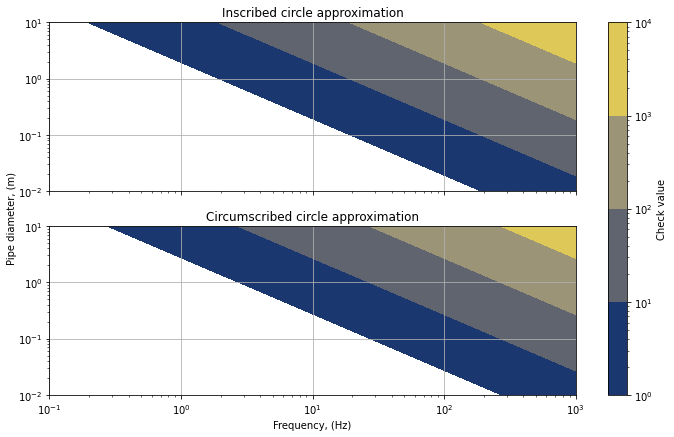

In [50]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
fig.set_size_inches(10, 10/1.618)

axes[0].set_yscale('log')
axes[0].set_xscale('log')
axes[0].grid(which='major')
axes[0].set_xlim(np.min(freqs), np.max(freqs))
axes[0].set_ylim(np.min(pipe_diameters), np.max(pipe_diameters))
contour = axes[0].contourf(xv, yv, check_value_out_ma, cmap='cividis', norm=colors.LogNorm())

axes[1].set_yscale('log')
axes[1].set_xscale('log')
axes[1].grid(which='major')
axes[1].set_xlim(np.min(freqs), np.max(freqs))
axes[1].set_ylim(np.min(pipe_diameters), np.max(pipe_diameters))
contour = axes[1].contourf(xv, yv, check_value_in_ma, cmap='cividis', norm=colors.LogNorm())

axes[0].set_title('Inscribed circle approximation')
axes[1].set_title('Circumscribed circle approximation')
axes[1].set_xlabel('Frequency, (Hz)')

fig.tight_layout()

cbar = fig.colorbar(contour, ax=axes.ravel().tolist())
cbar.set_label('Check value')

fig.text(0, 0.5, 'Pipe diameter, (m)', va='center', rotation='vertical')

# fig.savefig('4.png', dpi=600, bbox_inches='tight')


In [51]:
soil_temp = 10.0
soil_water_vol = 0.5
soil = p527.SOILS['silty_clay']
soil_permittivity = np.zeros(np.size(freqs), dtype=complex)

In [52]:
for idx, freq in enumerate(freqs):
    foo = p527.soil_permittivity(freq, soil_temp, soil.p_sand, soil.p_clay, soil.p_silt, soil_water_vol)
    # This is required as the functions calculating the complex relative permittivity do not apply the negative 
    # sign to the imaginary part. However, all other functions require the imaginary part to have a negative sign.
    soil_permittivity[idx] = complex(foo.real, -foo.imag)

In [53]:
for i, freq in enumerate(freqs):
    for j, diameter in enumerate(pipe_diameters):
        check_value_circ_eh11[i, j] = clw.check_electrical_size(freq, diameter, soil_permittivity[i], 1, 1, k_factor)
        check_value_circ_te01[i, j] = clw.check_electrical_size(freq, diameter, soil_permittivity[i], 0, 1, k_factor) 
        check_value_circ_te02[i, j] = clw.check_electrical_size(freq, diameter, soil_permittivity[i], 0, 2, k_factor)

In [54]:
# Similar treatment to before, mask out where the waveguide is not electrically large
check_value_circ_eh11_ma = np.ma.masked_where(check_value_circ_eh11 <= 1.0, check_value_circ_eh11)
check_value_circ_te01_ma = np.ma.masked_where(check_value_circ_te01 <= 1.0, check_value_circ_te01)
check_value_circ_te02_ma = np.ma.masked_where(check_value_circ_te02 <= 1.0, check_value_circ_te02)

Text(0, 0.5, 'Pipe diameter, (m)')

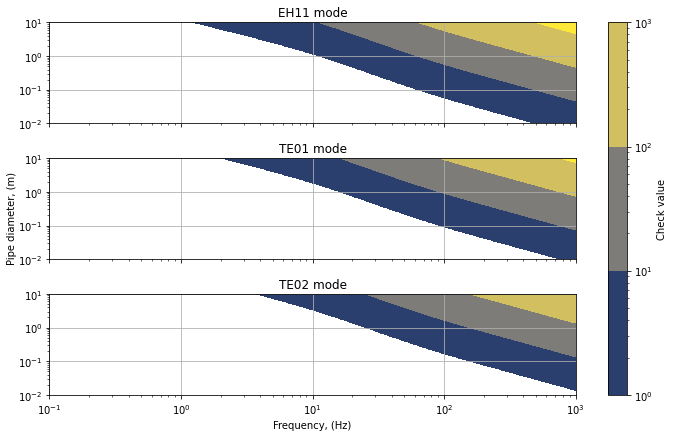

In [55]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True)
fig.set_size_inches(10, 10/1.618)

axes[0].set_yscale('log')
axes[0].set_xscale('log')
axes[0].grid(which='major')
axes[0].set_xlim(np.min(freqs), np.max(freqs))
axes[0].set_ylim(np.min(pipe_diameters), np.max(pipe_diameters))
contour = axes[0].contourf(xv, yv, check_value_circ_eh11_ma, cmap='cividis', norm=colors.LogNorm(vmin=1, vmax=1e3))

axes[1].set_yscale('log')
axes[1].set_xscale('log')
axes[1].grid(which='major')
axes[1].set_xlim(np.min(freqs), np.max(freqs))
axes[1].set_ylim(np.min(pipe_diameters), np.max(pipe_diameters))
contour = axes[1].contourf(xv, yv, check_value_circ_te01_ma, cmap='cividis', norm=colors.LogNorm(vmin=1, vmax=1e3))

axes[2].set_yscale('log')
axes[2].set_xscale('log')
axes[2].grid(which='major')
axes[2].set_xlim(np.min(freqs), np.max(freqs))
axes[2].set_ylim(np.min(pipe_diameters), np.max(pipe_diameters))
contour = axes[2].contourf(xv, yv, check_value_circ_te02_ma, cmap='cividis', norm=colors.LogNorm(vmin=1, vmax=1e3))

axes[0].set_title('EH11 mode')
axes[1].set_title('TE01 mode')
axes[2].set_title('TE02 mode')
axes[2].set_xlabel('Frequency, (Hz)')

fig.tight_layout()

cbar = fig.colorbar(contour, ax=axes.ravel().tolist())
cbar.set_label('Check value')

fig.text(0, 0.5, 'Pipe diameter, (m)', va='center', rotation='vertical')
# fig.savefig('Silty Clay 2.png', dpi=600, bbox_inches='tight')

In [56]:
import rectangular_lossy_waveguide as rlw

The module `rectangular_lossy_waveguide` implements similar functionality to that of `itur_p2040`. However, the formulas here are from a series of research papers, and are generalised to cover higher order modes, not just EH11.

In [57]:
check_value_rect = np.zeros((np.size(freqs), np.size(pipe_diameters)))

In [58]:
for i, freq in enumerate(freqs):
    for j, diameter in enumerate(pipe_diameters):
        check_value_rect[i, j] = rlw.check_electrical_size(freq, diameter/2, 1, k_factor)

In [59]:
check_value_rect_ma = np.ma.masked_where(check_value_rect <= 1, check_value_rect)

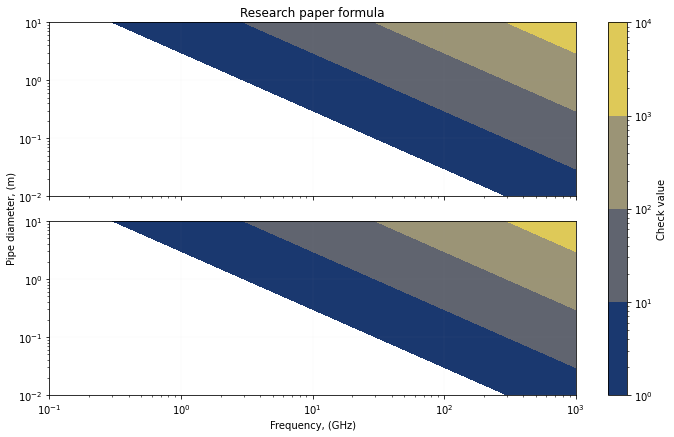

In [60]:
fig, axes = plt.subplots(ncols=1, nrows=2, sharex=True)
fig.set_size_inches(10, 10/1.618)

axes[0].set_yscale('log')
axes[0].set_xscale('log')
axes[0].grid(which='major', lw=0.05)
axes[0].set_xlim(np.min(freqs), np.max(freqs))
axes[0].set_ylim(np.min(pipe_diameters), np.max(pipe_diameters))
contour = axes[0].contourf(xv, yv, check_value_rect_ma, cmap='cividis', norm=colors.LogNorm(vmin=1, vmax=1e4))

# This plots the same data again in the second subplot. The reason is to create figures 
# which are easier to manually compare side by side.
axes[1].set_yscale('log')
axes[1].set_xscale('log')
axes[1].grid(which='major', lw=0.05)
axes[1].set_xlim(np.min(freqs), np.max(freqs))
axes[1].set_ylim(np.min(pipe_diameters), np.max(pipe_diameters))
contour = axes[1].contourf(xv, yv, check_value_rect_ma, cmap='cividis', norm=colors.LogNorm(vmin=1, vmax=1e4))

axes[0].set_title('Research paper formula')
axes[1].set_xlabel('Frequency, (GHz)')

fig.text(0, 0.5, 'Pipe diameter, (m)', va='center', rotation='vertical')

fig.tight_layout()
cbar = fig.colorbar(contour, ax=axes.ravel().tolist())
cbar.set_label('Check value')

# fig.savefig('1.png', dpi=600, bbox_inches='tight')


In [61]:
import circular_metal_waveguide as cmw

The module `circular_metal_waveguide` implements the bare minimum required for a metal waveguide with a circular cross-section. In this notebook, it is used to calculate the cut-off frequencies of the first five modes.

Please note that the modes propagating in a circular lossy waveguide are quite different, and the waveguide itself does not have cut-off frequencies per se. However this is still a good estimate of what frequencies are likely to exhibit waveguide propagation, and what frequencies are likely to just radiate into the soil.

In [62]:
cutoff_te11 = np.zeros(np.size(pipe_diameters))
cutoff_te01 = np.zeros(np.size(pipe_diameters))
cutoff_te02 = np.zeros(np.size(pipe_diameters))
cutoff_tm01 = np.zeros(np.size(pipe_diameters))
cutoff_tm02 = np.zeros(np.size(pipe_diameters))

In [63]:
for idx, diameter in enumerate(pipe_diameters):
    cutoff_te11[idx] = cmw.calc_cutoff_frequency(diameter, 'te', 1, 1)
    cutoff_te01[idx] = cmw.calc_cutoff_frequency(diameter, 'te', 0, 1)
    cutoff_te02[idx] = cmw.calc_cutoff_frequency(diameter, 'te', 0, 2)
    cutoff_tm01[idx] = cmw.calc_cutoff_frequency(diameter, 'tm', 0, 1)
    cutoff_tm02[idx] = cmw.calc_cutoff_frequency(diameter, 'tm', 0, 2)

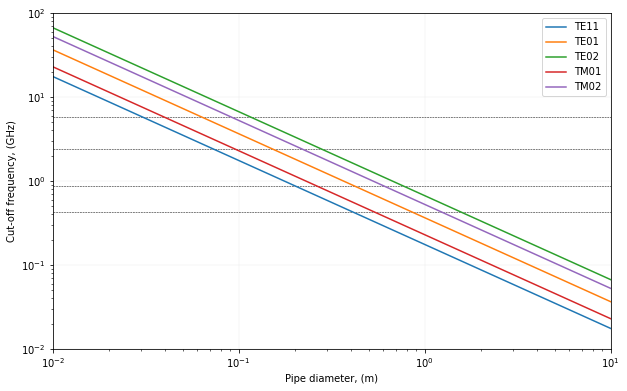

In [64]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10/1.618)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(np.min(pipe_diameters), np.max(pipe_diameters))
ax.set_ylim(0.01, 1e2)

ax.plot(pipe_diameters, cutoff_te11, label='TE11')
ax.plot(pipe_diameters, cutoff_te01, label='TE01')
ax.plot(pipe_diameters, cutoff_te02, label='TE02')
ax.plot(pipe_diameters, cutoff_tm01, label='TM01')
ax.plot(pipe_diameters, cutoff_tm02, label='TM02')

ax.hlines(0.433, np.min(pipe_diameters), np.max(pipe_diameters), ls='--', lw=0.5)
ax.hlines(0.868, np.min(pipe_diameters), np.max(pipe_diameters), ls='--', lw=0.5)
ax.hlines(2.4, np.min(pipe_diameters), np.max(pipe_diameters), ls='--', lw=0.5)
ax.hlines(5.8, np.min(pipe_diameters), np.max(pipe_diameters), ls='--', lw=0.5)

ax.grid(which='major', lw=0.1)

ax.set_xlabel('Pipe diameter, (m)')
ax.set_ylabel('Cut-off frequency, (GHz)')

ax.legend()

# fig.savefig('1.png', dpi=600, bbox_inches='tight')